In [1]:
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm

from src.utils.other import get_eval_log_path
%load_ext autoreload
%autoreload 2
from pyrootutils import pyrootutils
from hydra import initialize, compose
from os import path
import os
root = pyrootutils.setup_root(os.path.abspath(''), indicator=".project-root", pythonpath=True)

from src.utils.visualization.run_plotter import RunPlotter, MultiRunPlotter


config_path = os.path.relpath(os.path.join(root, "configs"), os.path.abspath(''))
with initialize(version_base=None, config_path=config_path):
    cfg = compose(overrides=[], config_name="notebook")

[[], [], [], [], []]
Total mean error for 300eR: 0.022727571427822113
Total mean error for w300: 0.059261634945869446
Total mean error for w300-N2T999: 0.022872457280755043
Total mean error for w300-UN2T95: 0.022807927802205086
Total mean error for w20: 0.03446614369750023


/mnt/c/Users/paulk/PycharmProjects/ma-dsme/src/utils/visualization/run_plotter.py:206: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/mnt/c/Users/paulk/PycharmProjects/ma-dsme/src/utils/visualization/run_plotter.py:843: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


| Run         |   Score mean  |     Std |
|-------------|---------------|---------|
| 300eR       |       11205.8 | 7214.12 |
| w300        |       13212.8 | 8523.67 |
| w300-N2T999 |       11299.7 | 7282.52 |
| w300-UN2T95 |       11274.5 | 7264.63 |
| w20         |       11271   | 7188.11 |


/mnt/c/Users/paulk/PycharmProjects/ma-dsme/src/utils/visualization/run_plotter.py:893: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


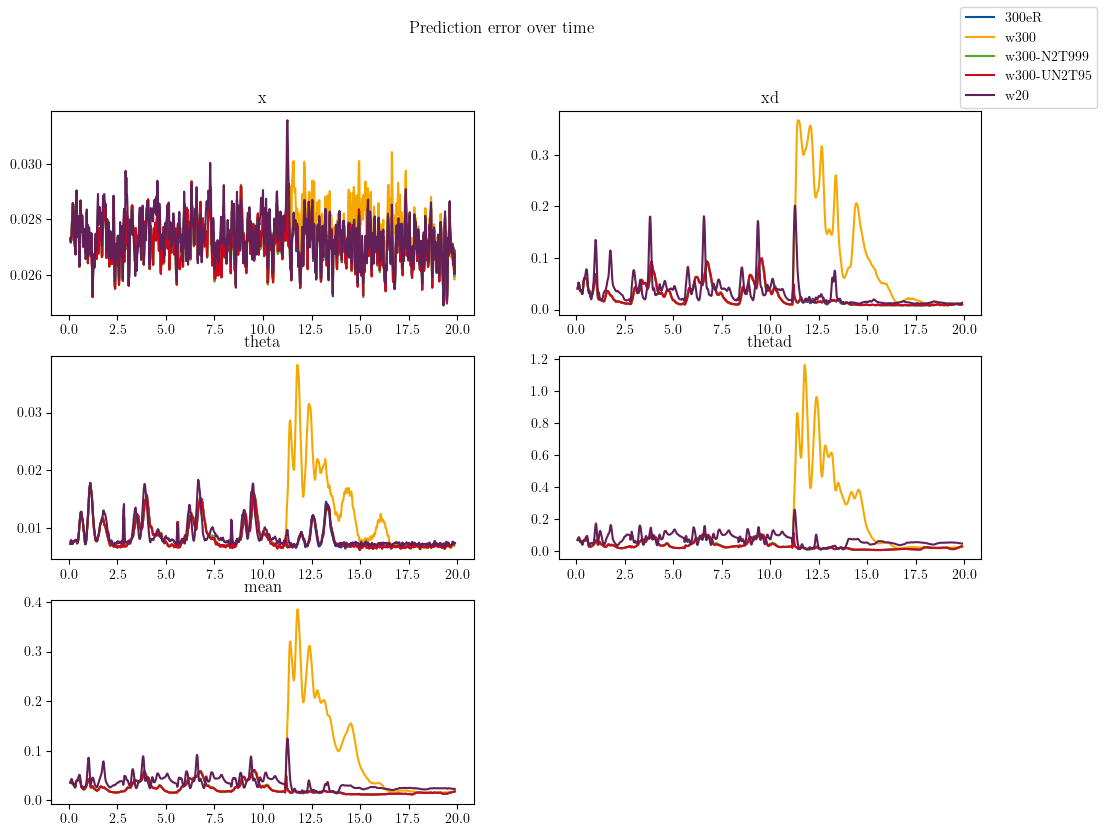

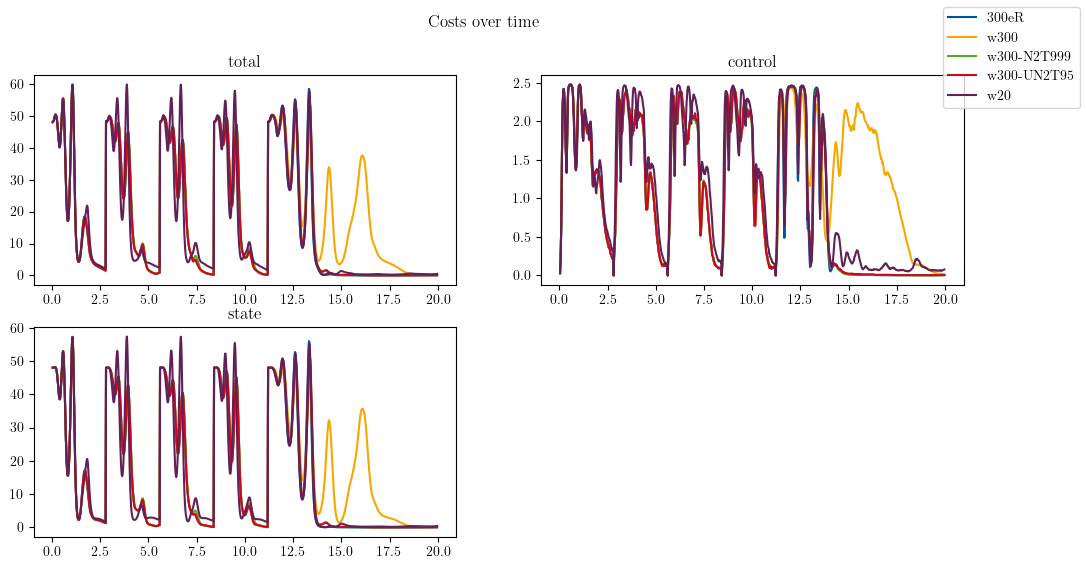

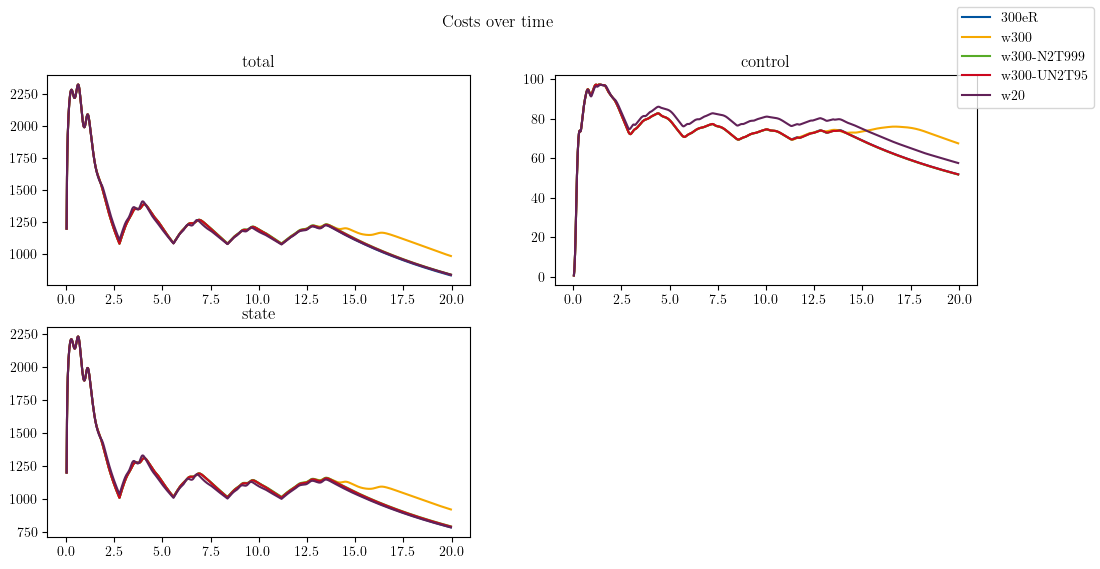

In [2]:
from src.systems.systems.dynamic_system import InvertedPendulumType
def get_achied_swingups(runs_all):
    achieved_idxs = []
    for run in runs_all:
        idx = []
        for i, episode in enumerate(run):
            theta = episode.system.system_states[:, 2]
            length = len(theta)
            theta_part = torch.cos(theta[int(length/2):])
            # Check if the pendulum is up for the last half of the episode
            if torch.all(theta_part > 0):
                idx.append(i)
        achieved_idxs.append(idx)
    return achieved_idxs

paths = [
    get_eval_log_path(cfg, "invP_eval/ETL/control_oneChange/multiDay2/win300-eR/multiruns/get_latest_folder/0/control_test__results.pkl.gzip"),
    get_eval_log_path(cfg, "invP_eval/ETL/control_oneChange/multiDay2/win300/multiruns/get_latest_folder/0/control_test__results.pkl.gzip"),
    get_eval_log_path(cfg, "invP_eval/ETL/control_oneChange/multiDay2/win300-N2T999/multiruns/2023-12-18_15-21-59/0/control_test__results.pkl.gzip"),
    get_eval_log_path(cfg, "invP_eval/ETL/control_oneChange/multiDay2/win300-UN2T95/multiruns/2023-12-18_15-21-20/0/control_test__results.pkl.gzip"),
    get_eval_log_path(cfg, "invP_eval/ETL/control_oneChange/multiDay2/win20/multiruns/get_latest_folder/0/control_test__results.pkl.gzip"),
]

#With process noise 0.01 * magnitude
#With 0.001 observation noise

plotter = MultiRunPlotter(InvertedPendulumType())
runs_all = plotter.load_pkl(paths, run_idx=None)
achieved_idxs = get_achied_swingups(runs_all)
print(achieved_idxs)
runs_achieved = [plotter.load_pkl([path], run_idx=idxs)[0] for path, idxs in zip(paths, achieved_idxs)]

plotter.plot_error_over_time(runs_all, labels=["300eR", "w300", "w300-N2T999", "w300-UN2T95", "w20"],
                             std=False, move_avg=3, normalize=True,
                             exlude_time_steps=[140, 280, 420, 560])
plotter.plot_costs(runs_all, labels=["300eR", "w300", "w300-N2T999", "w300-UN2T95", "w20"], std=False)

plotter.plot_cum_costs(runs_all, labels=["300eR", "w300", "w300-N2T999", "w300-UN2T95", "w20"], std=False, time_normalization=True)

/mnt/c/Users/paulk/PycharmProjects/ma-dsme/src/utils/visualization/run_plotter.py:682: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


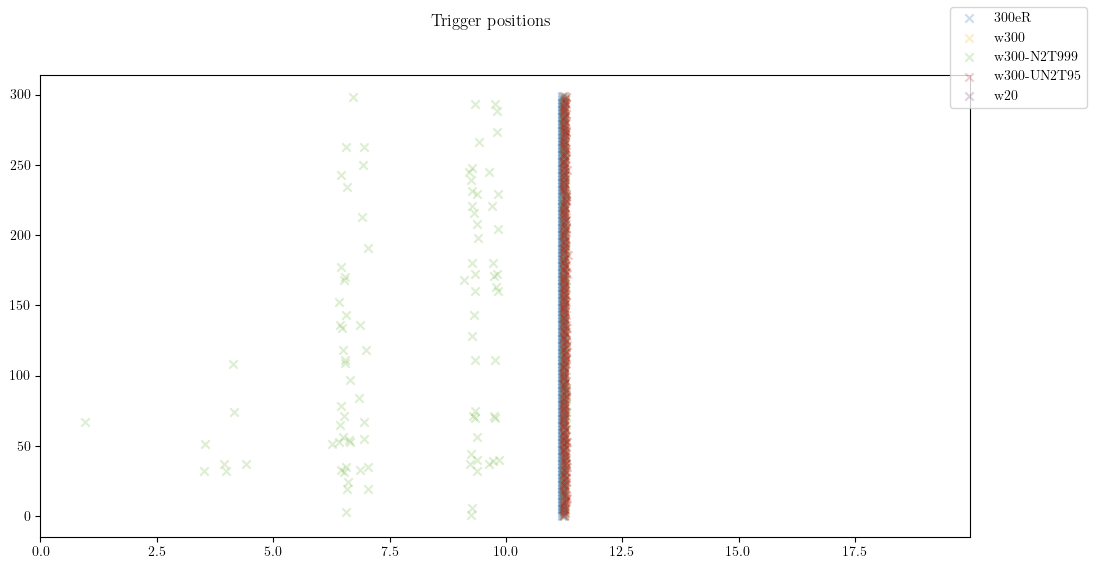

In [3]:
plotter.plot_trigger_points(runs_all, labels=["300eR", "w300", "w300-N2T999", "w300-UN2T95", "w20"])

In [4]:

for name, run in zip(["300eR", "w300", "w300-N2T999", "w300-UN2T95", "w20"], runs_all):

    costs = [episode.control.cost for episode in run]
    costs = torch.stack(costs)
    areas = [[0, 125], [125, 250], [250, 375], [375, 500]]
    constol_costs = []
    state_costs = []
    total_cost = []
    for area in areas:
        constol_costs.append(costs[:, area[0]:area[1], 1].sum())
        state_costs.append(costs[:, area[0]:area[1], 2].sum())
        total_cost.append(costs[:, area[0]:area[1], 0].sum())
        
    #print as table
    import tabulate
    
    
    print(tabulate.tabulate([["Control"]+constol_costs, ["State"]+state_costs, ["Total"]+total_cost],
                            headers=[name]+[area[0] for area in areas]))
    print("\n")

300eR           0       125     250       375
-------  --------  --------  ------  --------
Control   61405.7   57557.6   52342   52233.1
State    862727    859722    839845  820071
Total    924133    917280    892187  872304


w300            0       125     250       375
-------  --------  --------  ------  --------
Control   61405.7   57557.6   52342   52233.1
State    862727    859722    839845  820071
Total    924133    917280    892187  872304


w300-N2T999           0       125       250       375
-------------  --------  --------  --------  --------
Control         61405.6   57423.4   52265.8   52138.6
State          862729    861903    843446    822401
Total          924135    919327    895711    874539


w300-UN2T95           0       125     250       375
-------------  --------  --------  ------  --------
Control         61405.7   57557.6   52342   52233.1
State          862727    859722    839845  820071
Total          924133    917280    892187  872304


w20             0 

-8.109614455994183


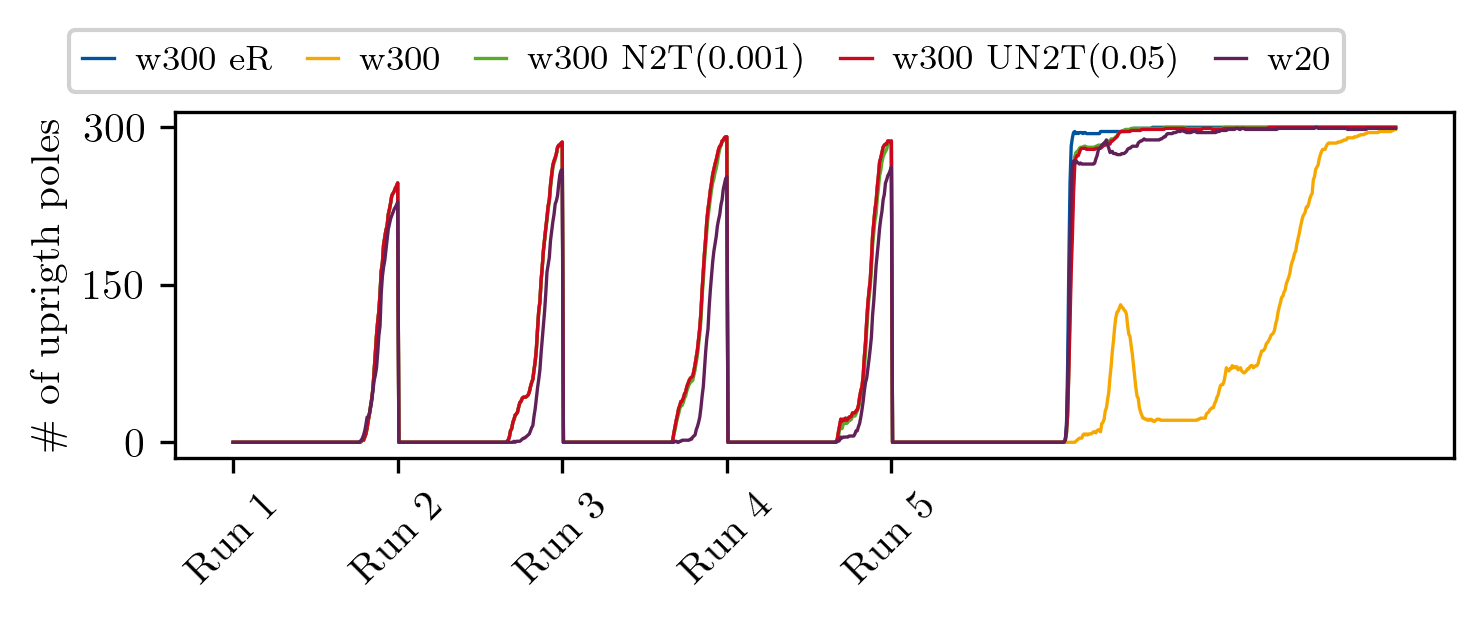

In [14]:
import numpy as np


def get_stable_pendulums(run, time_area=[0,560], window=10):
    """
    Returns the numer of stable pendulums for every time step in the time area
    The pendulum is considered stable if the cos(theta) is larger than 0.95
    """
    stable_pendulums = []
    for episode in run:
        theta = episode.system.system_states[time_area[0]:time_area[1], 2]
        theta_part = torch.cos(theta)
        upright = theta_part > 0.99
        tmp = torch.zeros(len(upright))
        # check if the pendulum is upright for window time steps
        for i in range(window, len(upright)):
            if torch.all(upright[i-window:i]):
                tmp[i] = 1
        stable_pendulums.append(tmp)
        #
        
    stable_pendulums = torch.stack(stable_pendulums)
    return stable_pendulums.sum(dim=0)

print((np.arccos(1)-np.arccos(0.99))*180/np.pi)

get_stable_pendulums(runs_all[0], time_area=[0,500])

linewidth = 0.8

fig = plt.figure(figsize=(5.5, 1.5), dpi=300)
time = torch.arange(0, 990, 1) * 0.02
fig.gca().plot(time, get_stable_pendulums(runs_all[0], time_area=[0,990]), label="w300 eR", linewidth=linewidth)
fig.gca().plot(time, get_stable_pendulums(runs_all[1], time_area=[0,990]), label="w300", linewidth=linewidth)
fig.gca().plot(time, get_stable_pendulums(runs_all[2], time_area=[0,990]), label="w300 N2T(0.001)", linewidth=linewidth)
fig.gca().plot(time, get_stable_pendulums(runs_all[3], time_area=[0,990]), label="w300 UN2T(0.05)", linewidth=linewidth)
fig.gca().plot(time, get_stable_pendulums(runs_all[4], time_area=[0,990]), label="w20", linewidth=linewidth)

data = {"data":[
    get_stable_pendulums(runs_all[0], time_area=[0,990]),
    get_stable_pendulums(runs_all[1], time_area=[0,990]),
    get_stable_pendulums(runs_all[2], time_area=[0,990]),
    get_stable_pendulums(runs_all[3], time_area=[0,990]),
    get_stable_pendulums(runs_all[4], time_area=[0,990]),
],
    "labels":["300eR", "w300", "w300-N2T(0.001)", "w300 UN2T(0.05)", "w20"],
    "time":time
}
#write as pickle
import pickle
with open("/tmp/stable_pendulums.pkl", "wb") as f:
    pickle.dump(data, f)

fig.gca().set_ylabel("\# of uprigth poles")

fig.gca().set_yticks([0, 150, 300])
fig.gca().set_xticks([tmp*0.02 for tmp in [0,140, 280,420, 560]], 
                     ["Run 1" , "Run 2", "Run 3", "Run 4", "Run 5"])
# turn x ticks by 45 degrees
for tick in fig.gca().get_xticklabels():
    tick.set_rotation(45)

fig.legend(loc='upper left', bbox_to_anchor=(.05, 1.1),
           ncol=7, fontsize="small",
           handlelength=0.9,
           columnspacing=1,
           handletextpad=0.6,
           framealpha=0.9)

fig.savefig("/tmp/stable_pendulums.pdf", bbox_inches="tight", transparent=True, facecolor=(1, 1, 1, 0))
fig.savefig("/tmp/stable_pendulums.png", bbox_inches="tight", transparent=True, facecolor=(1, 1, 1, 0))